# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import mlflow
import mlflow.sklearn
from common_functions import (eval_metrics, plot_cm)


%matplotlib inline

# Load Dataset

**Training set for Credit Card Transactions:**

* index - Unique Identifier for each row
* trans_date_trans_time - Transaction DateTime
* cc_num - Credit Card Number of Customer
* merchant - Merchant Name
* category - Category of Merchant
* amt - Amount of Transaction
* first - First Name of Credit Card Holder
* last - Last Name of Credit Card Holder
* gender - Gender of Credit Card Holder
* street - Street Address of Credit Card Holder
* city - City of Credit Card Holder
* state - State of Credit Card Holder
* zip - Zip of Credit Card Holder
* lat - Latitude Location of Credit Card Holder
* long - Longitude Location of Credit Card Holder
* city_pop - Credit Card Holder's City Population
* job - Job of Credit Card Holder
* dob - Date of Birth of Credit Card Holder
* trans_num - Transaction Number
* unix_time - UNIX Time of transaction
* merch_lat - Latitude Location of Merchant
* merch_long - Longitude Location of Merchant
* is_fraud - Fraud Flag <--- Target Class

In [2]:
train_data = pd.read_csv("raw_data/fraudTrain.csv")
train_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
train_data.shape

(1296675, 23)

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [5]:
train_data.isna().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

# Feature Selection

**Columns to be Droped and Reasons:**

* index: This is just a unique identifier and does not provide predictive power for the model.
* cc_num: Although it uniquely identifies a credit card, it’s sensitive information and can introduce data leakage. It likely won’t help in predicting fraud.
* first, last, gender, street, city, state, zip: These personal identifiers might not contribute meaningful insights into fraud detection and can lead to privacy concerns. They also may not generalize well across different datasets.
* trans_num: Similar to cc_num, this is a unique identifier for each transaction, providing little value for prediction.
* lat, long, merch_lat, merch_long: lat and long are personal location identifiers and merchant lat and long similarly give location of the merchant which mighth not add significant value.
* dob: using date of birth directly can raise privacy issues and doesn’t directly contribute to model performance.

**Columns to keep for prediction and reason**:

I tried to keep features that provide contextual or behavioral insights into transactions while removing those that are personal identifiers or have little predictive power.

* **trans_date_trans_time:** Temporal features can provide valuable insights (e.g., time of day, frequency of transactions).
* **merchant:** Merchant name can help identify patterns of fraud associated with specific merchants.
* **category:** This could be relevant for identifying trends in fraudulent transactions related to certain types of purchases.
* **amt:** Transaction amount is a critical feature for identifying anomalies.
* **city_pop:** This can provide context about the credit card holder's location, which may be relevant for fraud detection.
* **job:** Job may correlate with spending behavior, potentially helping to identify unusual patterns.
* **dob:** While age might correlate with certain fraud patterns, using date of birth directly can raise privacy issues and doesn’t directly contribute to model performance. So Age will be used instead of dob
* **is_fraud** - Fraud Flag <--- Target Class

In [6]:
train_data["is_fraud"].value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

* It is obvious here that the dataset is heavily imbalanced

In [7]:
df = train_data[["trans_date_trans_time", "merchant", "category", "amt", "city_pop", "job", "dob", "is_fraud"]].copy()
df.head()

,trans_date_trans_time,merchant,category,amt,city_pop,job,dob,is_fraud
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,3495,"Psychologist, counselling",1988-03-09,0
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,149,Special educational needs teacher,1978-06-21,0
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,4154,Nature conservation officer,1962-01-19,0
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,1939,Patent attorney,1967-01-12,0
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,99,Dance movement psychotherapist,1986-03-28,0


# Feature Engineering

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 8 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   merchant               1296675 non-null  object 
 2   category               1296675 non-null  object 
 3   amt                    1296675 non-null  float64
 4   city_pop               1296675 non-null  int64  
 5   job                    1296675 non-null  object 
 6   dob                    1296675 non-null  object 
 7   is_fraud               1296675 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 79.1+ MB


**Change transaction date and dob to datetime type**

In [9]:
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
df["dob"] = pd.to_datetime(df["dob"])

**Add Days, Day of the week , Month and Hour**

In [10]:
df["trans_day"] = df["trans_date_trans_time"].dt.day
df["trans_day_of_week"] = df["trans_date_trans_time"].dt.day_of_week
df["trans_hour"] = df["trans_date_trans_time"].dt.hour
df["trans_month"] = df["trans_date_trans_time"].dt.month

In [11]:
df.head()

,trans_date_trans_time,merchant,category,amt,city_pop,job,dob,is_fraud,trans_day,trans_day_of_week,trans_hour,trans_month
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,3495,"Psychologist, counselling",1988-03-09,0,1,1,0,1
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,149,Special educational needs teacher,1978-06-21,0,1,1,0,1
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,4154,Nature conservation officer,1962-01-19,0,1,1,0,1
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,1939,Patent attorney,1967-01-12,0,1,1,0,1
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,99,Dance movement psychotherapist,1986-03-28,0,1,1,0,1


**Add Age**

In [12]:
reference_date = pd.to_datetime("2020-12-31")
df["age"] = (reference_date-df["dob"]).dt.days // 365

**Dealing with categorical features using Frequency Encoding**

In [13]:
df["merchant"].nunique(), df["category"].nunique(), df["job"].nunique()

(693, 14, 494)

In [14]:
# Frequency encoding for job
job_freq = df["job"].value_counts()
df["job_encoded"] = df["job"].map(job_freq)

In [15]:
# merchant encoding for job
job_freq = df["merchant"].value_counts()
df["merchant_encoded"] = df["merchant"].map(job_freq)

In [16]:
# Category encoding for job
job_freq = df["category"].value_counts()
df["category_encoded"] = df["category"].map(job_freq)

**Drop Columns**

In [17]:
cols_to_drop = ["merchant", "job", "category", "dob", "trans_date_trans_time"]

In [18]:
df = df.drop(labels=cols_to_drop, axis="columns")

In [19]:
df.head()

,amt,city_pop,is_fraud,trans_day,trans_day_of_week,trans_hour,trans_month,age,job_encoded,merchant_encoded,category_encoded
0,4.97,3495,0,1,1,0,1,32,3545,1267,63287
1,107.23,149,0,1,1,0,1,42,5099,2503,123638
2,220.11,4154,0,1,1,0,1,58,511,1895,94014
3,45.00,1939,0,1,1,0,1,54,2530,2613,131659
4,41.96,99,0,1,1,0,1,34,2017,1592,79655


# Correlation Plot

<Axes: >

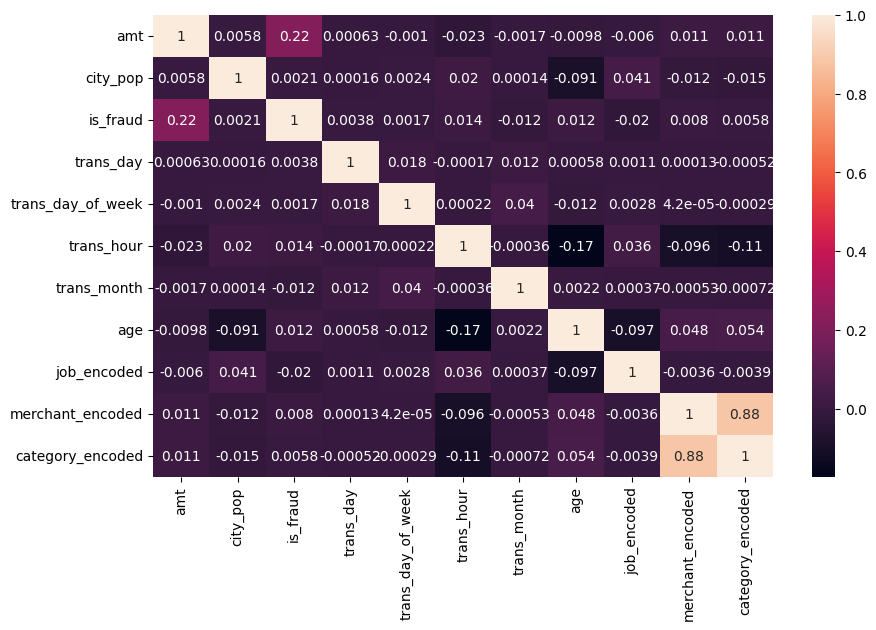

In [20]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True)

* There is a strong correlation between merchant encoded and category encoded.
* This make sense if a particular shop specialises in one category but nowadays that is difficult since shops usually cut across many categories.
* However for this purpose, I will drop merchant encoded.

In [21]:
df = df.drop(labels=["merchant_encoded"], axis="columns")

# Identify and drop druplicates

In [22]:
df.duplicated().sum()

5

In [23]:
df.shape

(1296675, 10)

In [24]:
df = df.drop_duplicates()

In [25]:
df.shape

(1296670, 10)

# Feature Scaling

In [26]:
X = df.drop(labels=["is_fraud"], axis="columns")
y = df[["is_fraud"]].values

In [27]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Isolation Forest

In [28]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, balanced_accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

**Params**

In [29]:
params = {"contamination": 0.02}
params

{'contamination': 0.02}

In [30]:
iso_forest = IsolationForest(random_state=42, contamination=params["contamination"])
iso_forest.fit(X_scaled)

IsolationForest(contamination=0.02, random_state=42)

In [31]:
# Predict anomalies (1 for normal, -1 for anomaly)
train_preds = iso_forest.predict(X_scaled)

In [32]:
train_preds = [1 if x == -1 else 0 for x in train_preds]

In [33]:
# Print evaluation metrics
cm = confusion_matrix(y, train_preds)
cm

array([[1266616,   22548],
       [   4120,    3386]], dtype=int64)

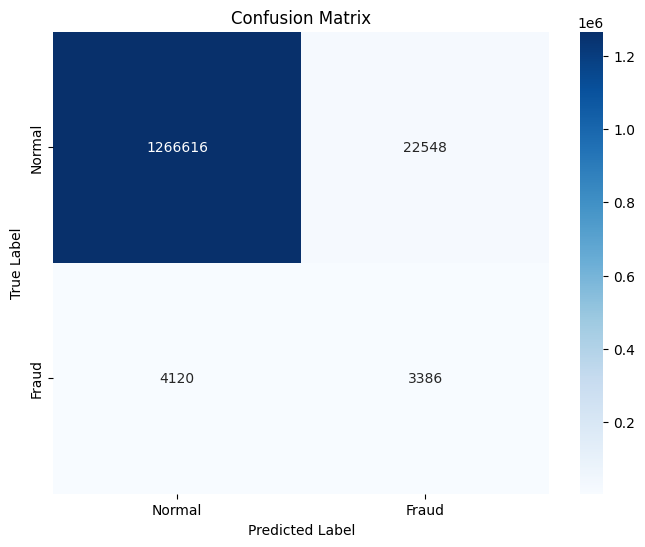

In [34]:
plot_cm(cm)

In [35]:
print(classification_report(y, train_preds))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1289164
           1       0.13      0.45      0.20      7506

    accuracy                           0.98   1296670
   macro avg       0.56      0.72      0.60   1296670
weighted avg       0.99      0.98      0.99   1296670



In [36]:
matthews_corrcoef(y, train_preds)

0.2349636174606281

In [37]:
balanced_accuracy_score(y, train_preds)

0.7168076887033563

In [38]:
roc_auc_score(y, train_preds)

0.7168076887033563

**Include MLflow**

In [39]:
mlflow.set_tracking_uri(uri="")

In [40]:
print("The Tracking URI is - ", mlflow.get_tracking_uri())

The Tracking URI is -  


In [46]:
#exp_id = mlflow.create_experiment(name="isolation_forest_exp", tags={"version":"v0"})

In [42]:
exp = mlflow.set_experiment(experiment_name="isolation_forest_exp")
exp_id = exp.experiment_id

In [43]:
#Auto logging
mlflow.sklearn.autolog(log_input_examples=True)

In [44]:
params = {"contamination": 0.08}
params

{'contamination': 0.08}

2024/10/10 20:25:33 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[[1190100   99064]
 [   2836    4670]]


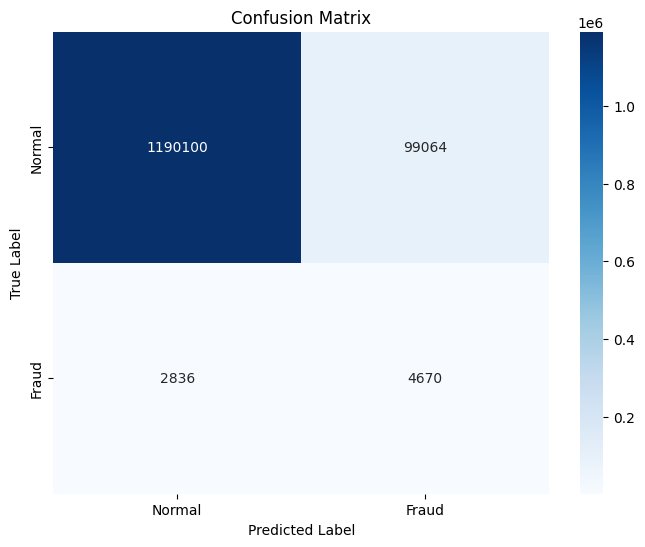

{'matthews': 0.15249124272816375, 'accuracy': 0.7726626668274625, 'roc': 0.7726626668274627, 'precision': 0.04501899088052133, 'recall': 0.6221689315214495, 'f1': 0.0839626033800791}
Artifact URI -  file:///C:/users/Dnemauluma/Work%20Folders/Training/Other_Datasets/credit-card-transactions-fraud-detection/mlruns/424328410538236926/de613c6d358444a5ba9131c37a2762af/artifacts

Experiment ID -  424328410538236926

Run ID -  de613c6d358444a5ba9131c37a2762af


In [45]:
with mlflow.start_run(experiment_id=exp_id):
   
    # Isolation forest model
    iso_forest = IsolationForest(random_state=42, contamination=params["contamination"])
    iso_forest.fit(X_scaled)

    # Predict anomalies (1 for normal, -1 for anomaly)
    y_pred = iso_forest.predict(X_scaled)
    y_pred = [1 if x == -1 else 0 for x in y_pred]

    #evaluation
    (matthews, accuracy, roc, precision, recall, f1) = eval_metrics(y,y_pred)

    # Print and plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    print(cm)

    plot_cm(cm)

    # log metrics and params

    metrics = {
    "matthews": matthews,
    "accuracy": accuracy,
    "roc": roc,
    "precision": precision,
    "recall": recall,
    "f1": f1,}
    #mlflow.log_metrics(metrics=metrics)

    print(metrics)

    #mlflow.log_params(params=params)

    # get some metadata
    artifact_uri = mlflow.get_artifact_uri()
    print("Artifact URI - ", artifact_uri)

    print("\nExperiment ID - ", exp_id)

    # Get the last run in the experiment
    run = mlflow.active_run()
    print("\nRun ID - ", run.info.run_id)

### Final Isolation Forest Model

* Due to the best f1 score and matthews coefficient, a contamination value of 0.1 was chosen for the best model 

2024/10/11 11:21:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'aaa93f360b0048b0ab6ba5945660b4b5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/10/11 11:21:53 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


[[1164378  124786]
 [   2625    4881]]


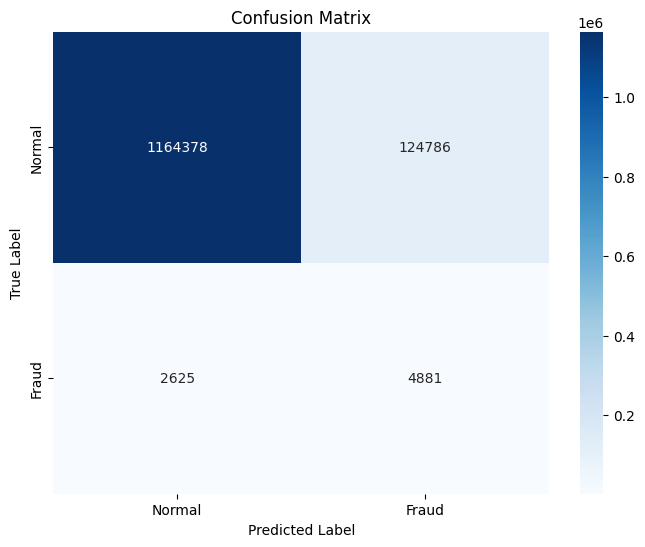

{'matthews': 0.1399627582758412, 'accuracy': 0.7767418564969615, 'roc': 0.7767418564969615, 'precision': 0.0376425767543014, 'recall': 0.6502797761790567, 'f1': 0.07116560839232211}
{'matthews': 0.1399627582758412, 'accuracy': 0.7767418564969615, 'roc': 0.7767418564969615, 'precision': 0.0376425767543014, 'recall': 0.6502797761790567, 'f1': 0.07116560839232211}


In [50]:
# Isolation forest model
iso_forest = IsolationForest(random_state=42, contamination=0.1)
iso_forest.fit(X_scaled)

# Predict anomalies (1 for normal, -1 for anomaly)
y_pred = iso_forest.predict(X_scaled)
y_pred = [1 if x == -1 else 0 for x in y_pred]

#evaluation
(matthews, accuracy, roc, precision, recall, f1) = eval_metrics(y,y_pred)

# Print and plot confusion matrix
cm = confusion_matrix(y, y_pred)
print(cm)

plot_cm(cm)

# log metrics and params

metrics = {
"matthews": matthews,
"accuracy": accuracy,
"roc": roc,
"precision": precision,
"recall": recall,
"f1": f1,}
print(metrics)

print(metrics)